In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
import networkx as nx
import random
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy.spatial import cKDTree
from numpy.linalg import lstsq



# Class implementation


In [2]:
def compute_kernel_matrix(X, k):
    D = squareform(pdist(X))
    sig = np.median(np.sort(D, axis=1)[:, k])
    K = np.exp(-D ** 2 / sig ** 2)
    return K

def compute_laplacian(K):
    D_inv = np.diag(np.sum(K, axis=1) ** (-0.5))
    L = D_inv @ K @ D_inv
    return L

def compute_leading_eigenvectors(L, d):
    lam, v = np.linalg.eigh(L)
    sort_idx = np.argsort(lam)[::-1]
    return lam[sort_idx][:d], v[:, sort_idx][:, :d]

def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return image, hsv

def detect_shapes(image):
    polygon_mask = np.zeros(image.shape[:2], dtype=np.uint8)
    rectangles = []
    circles = []

    black_lower = np.array([0, 0, 0])
    black_upper = np.array([180, 255, 50])
    blue_lower = np.array([100, 150, 50])
    blue_upper = np.array([140, 255, 255])
    green_lower = np.array([40, 50, 50])
    green_upper = np.array([90, 255, 255])

    black_mask = cv2.inRange(image, black_lower, black_upper)
    contours, _ = cv2.findContours(black_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        cv2.drawContours(polygon_mask, [contour], -1, 255, thickness=cv2.FILLED)

    blue_mask = cv2.inRange(image, blue_lower, blue_upper)
    contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        rectangles.append((x, y, w, h))

    green_mask = cv2.inRange(image, green_lower, green_upper)
    contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        circles.append((int(x), int(y), int(radius)))

    return polygon_mask, rectangles, circles

def generate_random_points(mask, num_points=1000):
    points = []
    h, w = mask.shape
    while len(points) < num_points:
        x, y = random.randint(0, w - 1), random.randint(0, h - 1)
        if mask[y, x] == 255:
            points.append((x, y))
    return points

def build_graph(mask, rectangles):
    G = nx.grid_2d_graph(mask.shape[0], mask.shape[1])
    for x, y, w, h in rectangles:
        for i in range(x, x + w):
            for j in range(y, y + h):
                if (j, i) in G:
                    G.remove_node((j, i))
    return G

def compute_shortest_paths(G, points, circles):
    dist_matrix = np.zeros((len(points), len(circles))) # Renamed the variable
    for i, (px, py) in enumerate(points):
        for j, (cx, cy, _) in enumerate(circles):
            try:
                path_length = nx.shortest_path_length(G, (py, px), (cy, cx))
            except nx.NetworkXNoPath:
                path_length = float('inf')
            dist_matrix[i, j] = path_length # Use the new variable name
    return dist_matrix # Return the new variable name

In [3]:
# ====================================
# Area - create G^A
# ====================================

class PhysicalLayoutGraph:
    def __init__(self, image_path, num_points=500, embedding_dim=2, k=7):
        self.image_path = image_path
        self.num_points = num_points
        self.embedding_dim = embedding_dim
        self.k = k
        self._process_image()
        self._compute_adjacency()
        self._compute_embedding()
        self.dist_matrix = None

    def _process_image(self):
        image, gray = load_image(self.image_path)
        self.image = image
        self.gray = gray
        self.polygon_mask, self.rectangles, self.circles = detect_shapes(gray)

        self.G = build_graph(self.polygon_mask, self.rectangles)
        self.random_points = generate_random_points(self.polygon_mask, num_points=self.num_points)
        self.random_points = np.array(self.random_points)
        #self.df_points_with_signals = {'x': random_points_from_graph[:, 0], 'y': random_points_from_graph[:, 1]}

    def _compute_adjacency(self):
        self.kernel_matrix = compute_kernel_matrix(self.random_points, k=self.k)

    def _compute_embedding(self):
        L = compute_laplacian(self.kernel_matrix)
        print(self.embedding_dim + 1)
        lam, v = compute_leading_eigenvectors(L, self.embedding_dim + 1)
        self.embedding = v[:, 1:self.embedding_dim + 1]

    def get_embedding(self):
        return self.embedding

    def get_points(self):
        return self.random_points

    def plot_embedding(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.embedding[:, 0], self.embedding[:, 1])
        plt.title("Physical Layout Spectral Embedding")
        plt.show()

    def plot_on_layout(self, predicted_points, true_points, title="Predicted Layout Locations"):
      plt.figure(figsize=(8, 8))
      plt.imshow(self.polygon_mask, cmap='gray', alpha=0.5)
      plt.imshow(self.image, alpha=0.3)

      predicted_p = np.array(predicted_points)
      plt.scatter(predicted_p[:, 0], predicted_p[:, 1], color='red', s=50, label="Predicted Points")

      true_p = np.array(true_points)
      plt.scatter(true_p[:, 0], true_p[:, 1], color='green', s=50, label="True Points")

      plt.legend()
      plt.title(title)
      plt.show()

    def embedding_to_layout_xy(self, embedding_points):
        """
        Maps points from embedding space to nearest real (x,y) layout points.
        """
        # Build KDTree of embedding
        tree = cKDTree(self.embedding)

        # Find nearest neighbor indices
        dists, indices = tree.query(embedding_points)

        # Map to (X, Y) points
        real_points = np.array(self.random_points)[indices]

        return real_points


In [4]:
# ====================================
# SignalGraph - G^S
# ====================================

class SignalGraph:
    def __init__(self, signal_data, embedding_dim=2, k_nearest=7):
        self.signal_data = signal_data
        self.embedding_dim = embedding_dim
        self.k_nearest = k_nearest
        self._build_kernel()
        self._compute_embedding()

    def _build_kernel(self):
        self.kernel_matrix = compute_kernel_matrix(self.signal_data, k=self.k_nearest)

    def _compute_embedding(self):
        L = compute_laplacian(self.kernel_matrix)
        lam, v = compute_leading_eigenvectors(L, self.embedding_dim + 1)
        self.embedding = v[:, 1:self.embedding_dim + 1]

    def get_embedding(self):
        return self.embedding

    def plot_embedding(self):
        plt.figure(figsize=(6, 6))
        plt.scatter(self.embedding[:, 0], self.embedding[:, 1])
        plt.title("Signal Graph Spectral Embedding")
        plt.show()



In [24]:
# ====================================
# ManifoldMatcher
# ====================================

class ManifoldMatcher:
    def __init__(self):
        self.fitted = False
        self.layout_graph = None
        self.signal_graph = None
        self.aligned_signal_embedding = None
        self.labeled_indices = None # Store labeled indices

    # def fit(self, layout_graph, signal_graph, labeled_indices):
    #     """
    #     Fits the manifold matcher using labeled indices from pre-built graphs.

    #     Args:
    #         layout_graph (PhysicalLayoutGraph): The pre-built layout graph.
    #         signal_graph (SignalGraph): The pre-built signal graph.
    #         labeled_indices (list): List of indices to use for fitting.
    #     """
    #     self.layout_graph = layout_graph
    #     self.signal_graph = signal_graph
    #     self.labeled_indices = labeled_indices

    #     layout_embedding = layout_graph.get_embedding()
    #     signal_embedding = signal_graph.get_embedding()

    #     # Select embeddings for labeled data
    #     labeled_layout_embedding = layout_embedding[labeled_indices]
    #     labeled_signal_embedding = signal_embedding[labeled_indices]

    #     # Perform Procrustes alignment on labeled embeddings
    #     _, aligned_labeled_signal_embedding, _ = self._procrustes(labeled_layout_embedding, labeled_signal_embedding)

    #     # Store the aligned embedding of the *labeled* signal data
    #     self.aligned_labeled_signal_embedding = aligned_labeled_signal_embedding

    #     self.fitted = True

    def fit(self, layout_graph, signal_graph, labeled_indices):
        self.layout_graph = layout_graph
        self.signal_graph = signal_graph
        self.labeled_indices = labeled_indices

        layout_embedding = layout_graph.get_embedding()
        signal_embedding = signal_graph.get_embedding()

        # Select embeddings for labeled data
        labeled_layout_embedding = layout_embedding[labeled_indices]  # shape (N, d)
        labeled_signal_embedding = signal_embedding[labeled_indices]  # shape (N, l)

        # Compute calibration matrix C via linear regression:
        #   solve: C @ layout.T ≈ signal.T  =>  signal.T = C @ layout.T
        #   transpose for lstsq: layout.T @ C.T = signal.T.T

        # Compute calibration matrix C via linear regression
        C_T, _, _, _ = lstsq(labeled_layout_embedding, labeled_signal_embedding, rcond=None)
        self.C = C_T.T  # shape (l, d) -> transpose to get (d, l)

        # Store aligned signal embeddings for labeled points (for visualization)
        self.aligned_labeled_signal_embedding = np.dot(labeled_layout_embedding, self.C.T)

        self.fitted = True


    def _procrustes(self, X, Y):
        X_mean = X.mean(0)
        Y_mean = Y.mean(0)
        X0 = X - X_mean
        Y0 = Y - Y_mean
        U, s, Vt = np.linalg.svd(Y0.T @ X0)
        R = U @ Vt
        Y_aligned = (Y0 @ R) + X_mean
        return X, Y_aligned, R

    def plot_alignment(self):
        if not self.fitted:
            raise ValueError("Not fitted yet.")

        plt.figure(figsize=(8, 8))
        # Plot the embedding of the labeled layout points used for fitting
        plt.scatter(self.layout_graph.get_embedding()[self.labeled_indices, 0], self.layout_graph.get_embedding()[self.labeled_indices, 1], label="Labeled Layout Embedding")
        # Plot the aligned embedding of the labeled signal data
        plt.scatter(self.aligned_labeled_signal_embedding[:, 0], self.aligned_labeled_signal_embedding[:, 1], label="Aligned Labeled Signal Embedding", alpha=0.7)
        plt.legend()
        plt.title("Manifold Matching Alignment (Labeled Data)")
        plt.show()

    def predict(self, new_signal_data):
        """
        Predicts layout locations for new signal data.

        Args:
            new_signal_data (np.ndarray): Array of new signal data points.

        Returns:
            np.ndarray: Predicted (x, y) layout coordinates for the new signal data.
        """
        if not self.fitted:
            raise ValueError("Not fitted yet.")

        # Compute kernel similarities between new signals and *all* signals used to build the signal_graph
        D = distance_matrix(new_signal_data, self.signal_graph.signal_data)
        sig = np.median(np.sort(D, axis=1)[:, self.signal_graph.k_nearest - 1]) # Use the k from the signal graph for all data
        K = np.exp(-D ** 2 / sig ** 2)

        # Handle rows with all zeros in K (can happen if a new signal is very far from all training signals)
        sum_K = K.sum(axis=1, keepdims=True)
        sum_K[sum_K == 0] = 1e-10 # Avoid division by zero

        # # Project new signals to the signal embedding space (built on all data)
        # projected = np.dot(K, self.signal_graph.get_embedding()) / sum_K

        # # Align to layout space using the transformation learned from labeled data
        # # We need to apply the same transformation (mean centering, scaling, rotation)
        # # derived from the labeled data Procrustes alignment.

        # # Recalculate Procrustes transformation for the labeled data to get the transformation matrix R
        # labeled_signal_embedding = self.signal_graph.get_embedding()[self.labeled_indices]
        # labeled_layout_embedding = self.layout_graph.get_embedding()[self.labeled_indices]

        # labeled_signal_mean = labeled_signal_embedding.mean(0)
        # labeled_layout_mean = labeled_layout_embedding.mean(0)
        # labeled_signal_centered = labeled_signal_embedding - labeled_signal_mean
        # labeled_layout_centered = labeled_layout_embedding - labeled_layout_mean

        # U, s, Vt = np.linalg.svd(labeled_layout_centered.T @ labeled_signal_centered)
        # R = U @ Vt

        # # Apply the transformation to the projected new signals
        # projected_centered = projected - labeled_signal_mean
        # aligned_predicted_embedding = (projected_centered @ R) + labeled_layout_mean

        # # Map aligned embedding points to nearest real (x,y) layout points (from *all* layout points)
        # predicted_real_locations = self.layout_graph.embedding_to_layout_xy(aligned_predicted_embedding)

        # Project new signals to signal embedding space
        projected = np.dot(K, self.signal_graph.get_embedding()) / sum_K

        # Align to layout space using calibration matrix C
        aligned_predicted_embedding = np.dot(self.C, self.layout_graph.get_embedding().T).T

        # Find nearest neighbor in layout space (1-NN search as in Eq. 10)
        tree = cKDTree(aligned_predicted_embedding)
        _, indices = tree.query(projected, k=1)

        # Get actual layout coordinates corresponding to the nearest neighbors
        predicted_real_locations = self.layout_graph.get_points()[indices]

        return predicted_real_locations

# Run

In [6]:
image_path = "C:\\Users\\Noa\\Documents\\Thesis\\data\\floor_plan_c.png"

# Build G^A
layout_graph = PhysicalLayoutGraph(image_path, num_points=500, embedding_dim=4, k=7)

5


In [7]:
layout_graph.dist_matrix = compute_shortest_paths(layout_graph.G, layout_graph.random_points, layout_graph.circles)
num_circles = layout_graph.dist_matrix.shape[1]  # Get the number of circles

In [8]:
print(f"Number of circles: {num_circles}")
signals = np.zeros_like(layout_graph.dist_matrix)  # Initialize signals array

for i in range(num_circles):
  signals[:, i] = np.log(1 / (layout_graph.dist_matrix[:, i]**2 + 1e-10))

Number of circles: 9


In [9]:
def calc_signals():
  image_path = 'C:\\Users\\Noa\\Documents\\Thesis\\data\\floor_plan_c.png'

  # Build G^A
  layout_graph = PhysicalLayoutGraph(image_path, num_points=500, embedding_dim=4, k=7)
  layout_graph.dist_matrix = compute_shortest_paths(layout_graph.G, layout_graph.random_points, layout_graph.circles)
  num_circles = layout_graph.dist_matrix.shape[1]  # Get the number of circles
  print(f"Number of circles: {num_circles}")
  signals = np.zeros_like(layout_graph.dist_matrix)  # Initialize signals array

  for i in range(num_circles):
    signals[:, i] = np.log(1 / (layout_graph.dist_matrix[:, i]**2 + 1e-10))

  return signals, layout_graph

In [10]:
def merge_signals_points(signals, random_points_from_graph):
  df_data = {
        'x': random_points_from_graph[:, 0],
        'y': random_points_from_graph[:, 1]}
  # Add signal columns
  for i in range(signals.shape[1]):
      df_data[f'signal_{i+1}'] = signals[:, i]

  points_with_signals_df = pd.DataFrame(df_data)
  return points_with_signals_df

In [11]:
signals, area_graph = calc_signals()

5
Number of circles: 9


In [12]:
pd.DataFrame(area_graph.embedding)

,0,1,2,3
0,-0.019136,0.001890,-0.000569,0.050767
1,0.103476,-0.036651,-0.002924,-0.005141
2,-0.032713,-0.030344,0.063847,-0.118293
3,-0.017074,-0.003140,0.000807,0.033109
4,-0.025304,-0.023063,-0.080465,-0.018096
...,...,...,...,...
495,-0.032537,-0.028210,-0.096166,-0.017372
496,-0.026782,-0.024235,-0.074929,-0.022681
497,0.016929,0.108723,-0.009380,-0.022283
498,0.020466,0.130121,-0.012581,-0.032903


In [13]:
pd.DataFrame(signals)

,0,1,2,3,4,5,6,7,8
0,-9.400961,-10.294989,-10.125190,-10.223976,-10.235988,-9.765604,-9.795680,-9.672564,-9.719625
1,-9.591581,-7.940584,-10.259797,-10.352299,-7.742402,-10.606610,-8.837681,-9.558247,-10.576534
2,-9.558247,-10.525380,-7.522400,-6.591674,-10.472884,-9.065199,-10.919171,-10.849900,-10.021271
3,-9.472397,-10.363567,-9.608042,-9.735069,-10.306583,-9.128696,-9.883285,-9.765604,-9.065199
4,-10.429872,-11.026857,-10.099712,-9.472397,-10.986123,-7.742402,-10.694215,-10.616535,-4.394449
...,...,...,...,...,...,...,...,...,...
495,-9.967213,-10.694215,-9.541369,-9.672564,-10.646020,-8.379309,-10.294989,-10.199733,-7.427144
496,-9.980865,-10.703716,-9.558247,-8.738896,-10.655752,-7.522400,-10.462217,-10.374772,-7.568379
497,-10.034560,-9.839962,-10.586610,-10.665438,-9.288782,-10.306583,-7.522400,-7.110696,-10.271597
498,-10.162809,-9.980865,-10.684669,-10.759795,-8.954674,-10.418972,-6.993015,-6.867974,-10.385914


In [14]:
points_with_signals_df = merge_signals_points(signals,area_graph.random_points)

In [15]:
points_with_signals_df

,x,y,signal_1,signal_2,signal_3,signal_4,signal_5,signal_6,signal_7,signal_8,signal_9
0,103,15,-9.400961,-10.294989,-10.125190,-10.223976,-10.235988,-9.765604,-9.795680,-9.672564,-9.719625
1,38,69,-9.591581,-7.940584,-10.259797,-10.352299,-7.742402,-10.606610,-8.837681,-9.558247,-10.576534
2,180,89,-9.558247,-10.525380,-7.522400,-6.591674,-10.472884,-9.065199,-10.919171,-10.849900,-10.021271
3,124,30,-9.472397,-10.363567,-9.608042,-9.735069,-10.306583,-9.128696,-9.883285,-9.765604,-9.065199
4,175,11,-10.429872,-11.026857,-10.099712,-9.472397,-10.986123,-7.742402,-10.694215,-10.616535,-4.394449
...,...,...,...,...,...,...,...,...,...,...,...
495,147,21,-9.967213,-10.694215,-9.541369,-9.672564,-10.646020,-8.379309,-10.294989,-10.199733,-7.427144
496,174,47,-9.980865,-10.703716,-9.558247,-8.738896,-10.655752,-7.522400,-10.462217,-10.374772,-7.568379
497,47,30,-10.034560,-9.839962,-10.586610,-10.665438,-9.288782,-10.306583,-7.522400,-7.110696,-10.271597
498,34,33,-10.162809,-9.980865,-10.684669,-10.759795,-8.954674,-10.418972,-6.993015,-6.867974,-10.385914


In [16]:
labeled_indices = [i for i in range(100)]

In [20]:
signal_graph = SignalGraph(signals, embedding_dim=4, k_nearest=7)

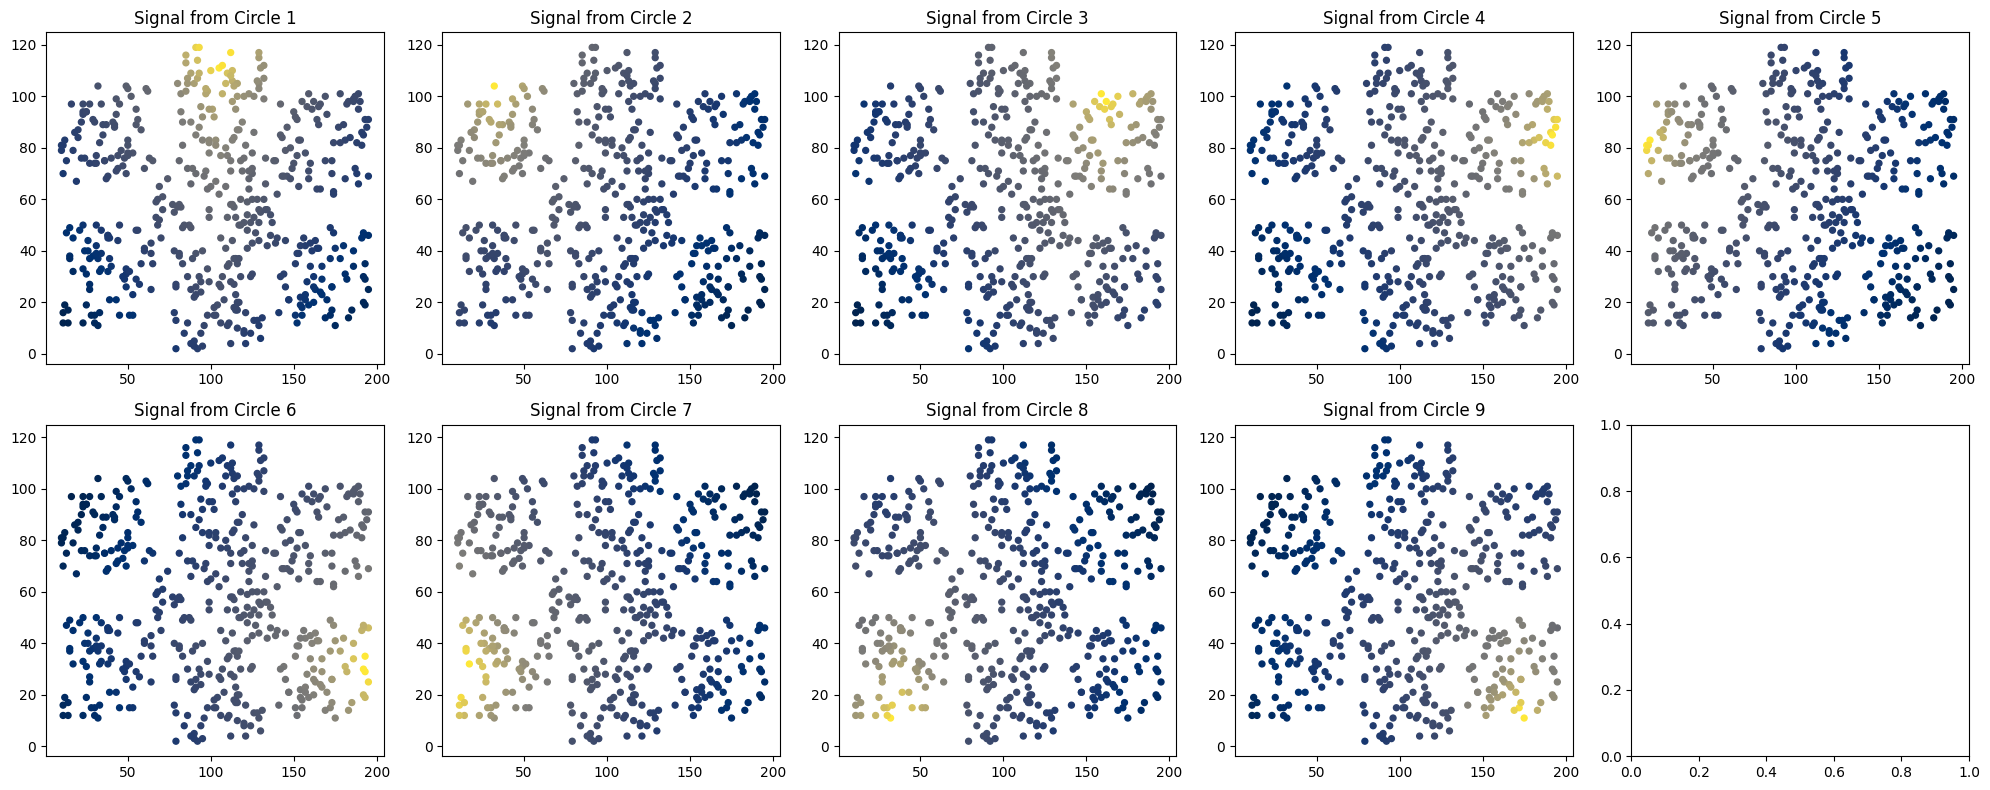

In [21]:
# Get the random points from the area_graph object
random_points_from_graph = area_graph.get_points()

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()[:9]):
    ax.scatter(random_points_from_graph[:, 0], random_points_from_graph[:, 1],
               c=np.log(1 / (area_graph.dist_matrix[:, i]**2)), s=18, cmap='cividis')
    ax.set_title(f'Signal from Circle {i+1}')

plt.tight_layout()
plt.show()

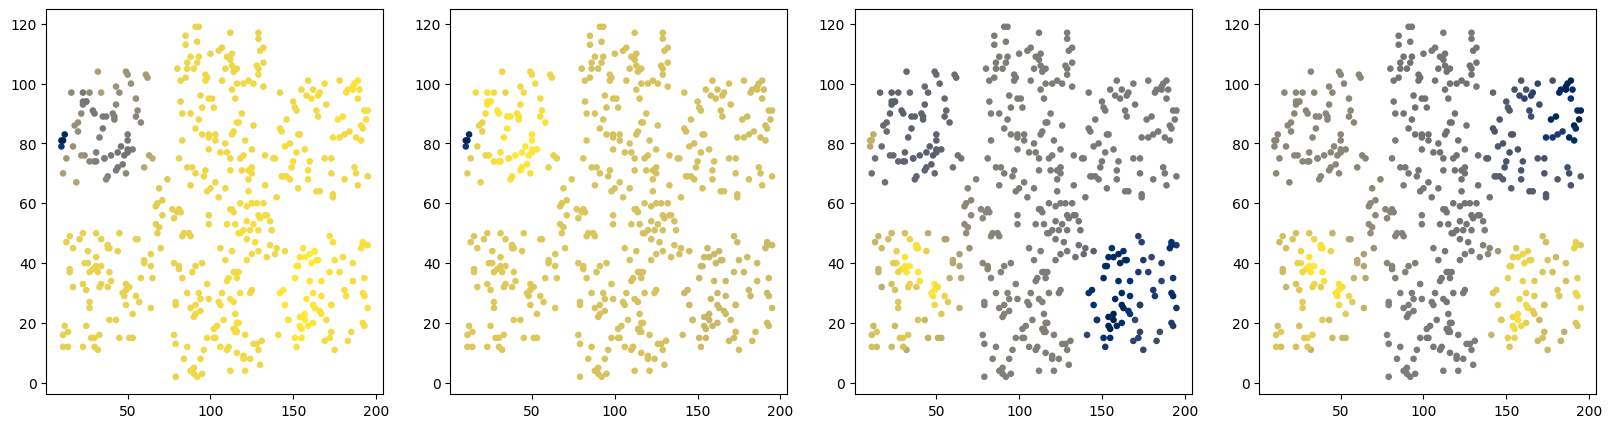

In [22]:
# Laplacian of the signals graph
K_sig = compute_kernel_matrix(signals,k = 7) # np.log(1/(area_graph.dist_matrix**2))
L_sig = compute_laplacian(K_sig)

lam,v_sig = compute_leading_eigenvectors(L_sig,30)
fig,axs = plt.subplots(1,4,figsize = (20,5))
for i,ax in enumerate(axs.flatten()):
    ax.scatter(random_points_from_graph[:,0],random_points_from_graph[:,1],c = v_sig[:,i+1],s = 14,cmap = 'cividis')
fig.savefig('eigenvectors_signals.png')

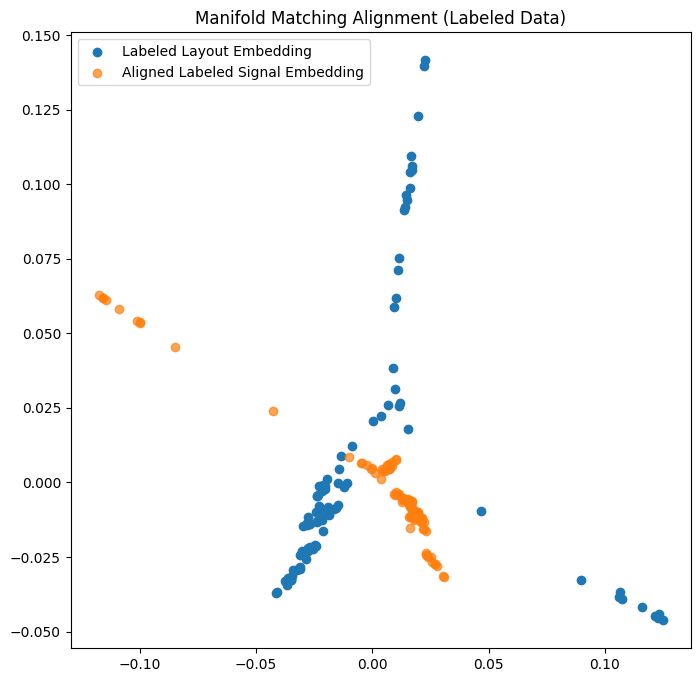

In [25]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)

# Define labeled indices
labeled_indices = [i for i in range(100,200)] # Use the first 20 points for fitting

# Initialize and fit the matcher using the pre-built graphs and labeled indices
matcher = ManifoldMatcher()
matcher.fit(area_graph, signal_graph, labeled_indices)

# Plot the alignment of the labeled data
matcher.plot_alignment()

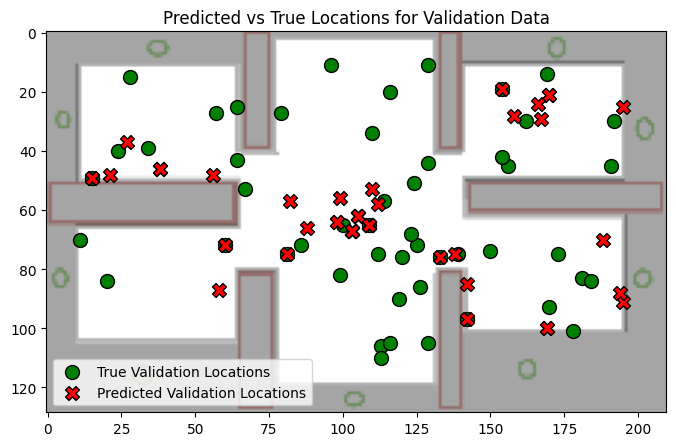

In [26]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)
# - matcher (ManifoldMatcher object, fitted on labeled_indices)
# - labeled_indices (list of indices used for fitting)

# Define validation indices (e.g., indices from 20 to 29)
# Make sure these indices are not in labeled_indices
validation_indices = list(range(200, 250))

# Important: Add a check to ensure validation_indices do not overlap with labeled_indices
if any(i in labeled_indices for i in validation_indices):
    raise ValueError("Validation indices overlap with labeled indices.")

# Extract signal data and true layout locations for validation points
validation_data = points_with_signals_df.iloc[validation_indices].copy()
validation_signal_data = validation_data.drop(['x', 'y'], axis=1).values
validation_true_real_locations = validation_data[['x', 'y']].values

# Predict locations for the validation signal data
predicted_locations_validation = matcher.predict(validation_signal_data)

# Plot the predicted and true locations for the validation data on the layout
plt.figure(figsize=(8, 8))
plt.imshow(area_graph.polygon_mask, cmap='gray', alpha=0.5)
plt.imshow(area_graph.image, alpha=0.3)

# Plot the true locations of the validation points
plt.scatter(validation_true_real_locations[:, 0], validation_true_real_locations[:, 1], color='green', s=100, label="True Validation Locations", marker='o', edgecolor='black')

# Plot the predicted locations of the validation points
plt.scatter(predicted_locations_validation[:, 0], predicted_locations_validation[:, 1], color='red', s=100, label="Predicted Validation Locations", marker='X', edgecolor='black')

plt.legend()
plt.title("Predicted vs True Locations for Validation Data")
plt.show()


# Evaluation

In [ ]:

# Evaluate the prediction on the validation data
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE) between predicted and true locations for validation data
mse_validation = mean_squared_error(validation_true_real_locations, predicted_locations_validation)
print(f"Mean Squared Error of predicted locations for validation data: {mse_validation}")

# Calculate average distance error for validation data
distances_validation = np.linalg.norm(validation_true_real_locations - predicted_locations_validation, axis=1)
average_distance_error_validation = np.mean(distances_validation)
print(f"Average distance error for validation data: {average_distance_error_validation}")

Mean Squared Error of predicted locations for validation data: 721.3
Average distance error for validation data: 32.86887478539167


In [ ]:

# Evaluate the prediction
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error (MSE) between predicted and true locations
mse = mean_squared_error(true_real_locations, predicted_locations)
print(f"Mean Squared Error of predicted locations: {mse}")

# Calculate average distance error
distances = np.linalg.norm(true_real_locations - predicted_locations, axis=1)
average_distance_error = np.mean(distances)
print(f"Average distance error: {average_distance_error}")

Mean Squared Error of predicted locations: 1347.83125
Average distance error: 45.80825369388797


# different calibration

In [27]:
# ====================================
# ManifoldMatcher
# ====================================

class ManifoldMatcher:
    def __init__(self):
        self.fitted = False
        self.layout_graph = None
        self.signal_graph = None
        self.aligned_signal_embedding = None
        self.labeled_indices = None # Store labeled indices

    def fit(self, layout_graph, signal_graph, labeled_indices):
        """
        Fits the manifold matcher using labeled indices from pre-built graphs.

        Args:
            layout_graph (PhysicalLayoutGraph): The pre-built layout graph.
            signal_graph (SignalGraph): The pre-built signal graph.
            labeled_indices (list): List of indices to use for fitting.
        """
        self.layout_graph = layout_graph
        self.signal_graph = signal_graph
        self.labeled_indices = labeled_indices

        layout_embedding = layout_graph.get_embedding()
        signal_embedding = signal_graph.get_embedding()

        # Select embeddings for labeled data
        labeled_layout_embedding = layout_embedding[labeled_indices]
        labeled_signal_embedding = signal_embedding[labeled_indices]

        # Perform Procrustes alignment on labeled embeddings
        _, aligned_labeled_signal_embedding, _ = self._procrustes(labeled_layout_embedding, labeled_signal_embedding)

        # Store the aligned embedding of the *labeled* signal data
        self.aligned_labeled_signal_embedding = aligned_labeled_signal_embedding

        self.fitted = True

    def _procrustes(self, X, Y):
        X_mean = X.mean(0)
        Y_mean = Y.mean(0)
        X0 = X - X_mean
        Y0 = Y - Y_mean
        U, s, Vt = np.linalg.svd(Y0.T @ X0)
        R = U @ Vt
        Y_aligned = (Y0 @ R) + X_mean
        return X, Y_aligned, R

    def plot_alignment(self):
        if not self.fitted:
            raise ValueError("Not fitted yet.")

        plt.figure(figsize=(8, 8))
        # Plot the embedding of the labeled layout points used for fitting
        plt.scatter(self.layout_graph.get_embedding()[self.labeled_indices, 0], self.layout_graph.get_embedding()[self.labeled_indices, 1], label="Labeled Layout Embedding")
        # Plot the aligned embedding of the labeled signal data
        plt.scatter(self.aligned_labeled_signal_embedding[:, 0], self.aligned_labeled_signal_embedding[:, 1], label="Aligned Labeled Signal Embedding", alpha=0.7)
        plt.legend()
        plt.title("Manifold Matching Alignment (Labeled Data)")
        plt.show()

    def predict(self, new_signal_data):
        """
        Predicts layout locations for new signal data.

        Args:
            new_signal_data (np.ndarray): Array of new signal data points.

        Returns:
            np.ndarray: Predicted (x, y) layout coordinates for the new signal data.
        """
        if not self.fitted:
            raise ValueError("Not fitted yet.")

        # Compute kernel similarities between new signals and *all* signals used to build the signal_graph
        D = distance_matrix(new_signal_data, self.signal_graph.signal_data)
        sig = np.median(np.sort(D, axis=1)[:, self.signal_graph.k_nearest - 1]) # Use the k from the signal graph for all data
        K = np.exp(-D ** 2 / sig ** 2)

        # Handle rows with all zeros in K (can happen if a new signal is very far from all training signals)
        sum_K = K.sum(axis=1, keepdims=True)
        sum_K[sum_K == 0] = 1e-10 # Avoid division by zero

        # Project new signals to the signal embedding space (built on all data)
        projected = np.dot(K, self.signal_graph.get_embedding()) / sum_K

        # Align to layout space using the transformation learned from labeled data
        # We need to apply the same transformation (mean centering, scaling, rotation)
        # derived from the labeled data Procrustes alignment.

        # Recalculate Procrustes transformation for the labeled data to get the transformation matrix R
        labeled_signal_embedding = self.signal_graph.get_embedding()[self.labeled_indices]
        labeled_layout_embedding = self.layout_graph.get_embedding()[self.labeled_indices]

        labeled_signal_mean = labeled_signal_embedding.mean(0)
        labeled_layout_mean = labeled_layout_embedding.mean(0)
        labeled_signal_centered = labeled_signal_embedding - labeled_signal_mean
        labeled_layout_centered = labeled_layout_embedding - labeled_layout_mean

        U, s, Vt = np.linalg.svd(labeled_layout_centered.T @ labeled_signal_centered)
        R = U @ Vt

        # Apply the transformation to the projected new signals
        projected_centered = projected - labeled_signal_mean
        aligned_predicted_embedding = (projected_centered @ R) + labeled_layout_mean

        # Map aligned embedding points to nearest real (x,y) layout points (from *all* layout points)
        predicted_real_locations = self.layout_graph.embedding_to_layout_xy(aligned_predicted_embedding)

        return predicted_real_locations

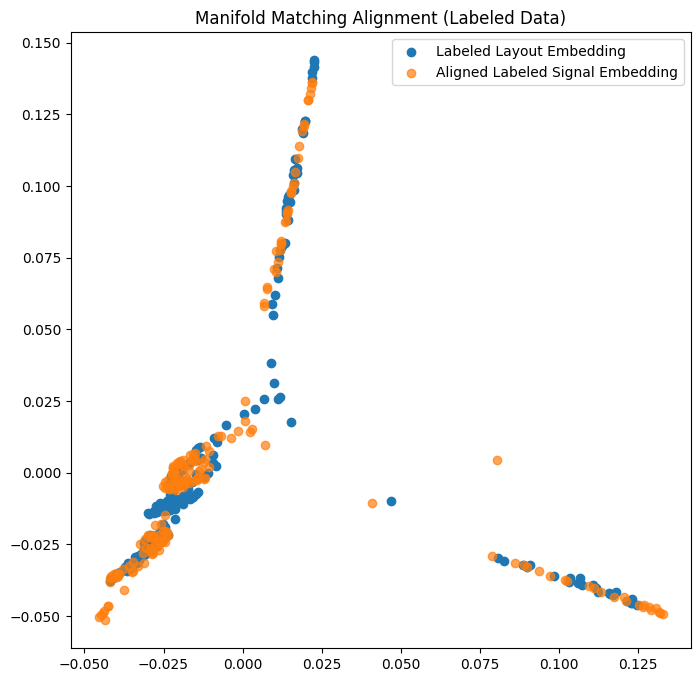

In [28]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)

# Define labeled indices
labeled_indices = [i for i in range(200)] # Use the first 20 points for fitting

# Initialize and fit the matcher using the pre-built graphs and labeled indices
matcher = ManifoldMatcher()
matcher.fit(area_graph, signal_graph, labeled_indices)

# Plot the alignment of the labeled data
matcher.plot_alignment()

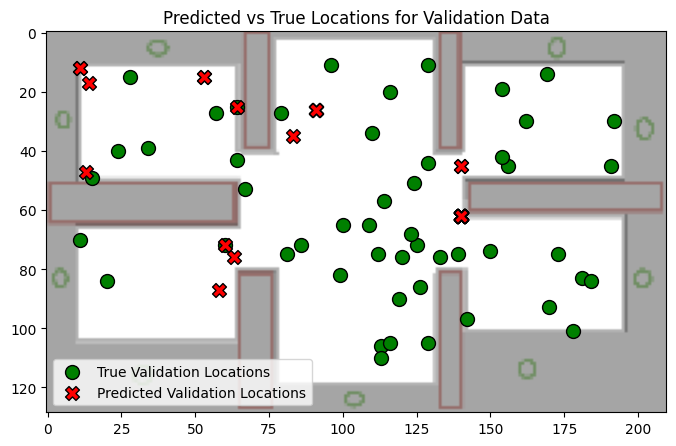

In [30]:
# Assuming you have already run the cells to create:
# - area_graph (PhysicalLayoutGraph built on all random_points)
# - signals (np.ndarray of signals for all random_points)
# - signal_graph (SignalGraph built on all signals)
# - points_with_signals_df (pd.DataFrame combining random_points and signals)
# - matcher (ManifoldMatcher object, fitted on labeled_indices)
# - labeled_indices (list of indices used for fitting)

# Define validation indices (e.g., indices from 20 to 29)
# Make sure these indices are not in labeled_indices
validation_indices = list(range(200, 250))

# Important: Add a check to ensure validation_indices do not overlap with labeled_indices
if any(i in labeled_indices for i in validation_indices):
    raise ValueError("Validation indices overlap with labeled indices.")

# Extract signal data and true layout locations for validation points
validation_data = points_with_signals_df.iloc[validation_indices].copy()
validation_signal_data = validation_data.drop(['x', 'y'], axis=1).values
validation_true_real_locations = validation_data[['x', 'y']].values

# Predict locations for the validation signal data
predicted_locations_validation = matcher.predict(validation_signal_data)

# Plot the predicted and true locations for the validation data on the layout
plt.figure(figsize=(8, 8))
plt.imshow(area_graph.polygon_mask, cmap='gray', alpha=0.5)
plt.imshow(area_graph.image, alpha=0.3)

# Plot the true locations of the validation points
plt.scatter(validation_true_real_locations[:, 0], validation_true_real_locations[:, 1], color='green', s=100, label="True Validation Locations", marker='o', edgecolor='black')

# Plot the predicted locations of the validation points
plt.scatter(predicted_locations_validation[:, 0], predicted_locations_validation[:, 1], color='red', s=100, label="Predicted Validation Locations", marker='X', edgecolor='black')

plt.legend()
plt.title("Predicted vs True Locations for Validation Data")
plt.show()


In [31]:
predicted_locations_validation

array([[140,  62],
       [140,  62],
       [140,  62],
       [ 91,  26],
       [ 63,  76],
       [ 91,  26],
       [140,  62],
       [140,  62],
       [ 91,  26],
       [140,  62],
       [140,  62],
       [140,  45],
       [140,  62],
       [ 91,  26],
       [140,  62],
       [ 91,  26],
       [140,  62],
       [140,  62],
       [ 64,  25],
       [140,  62],
       [140,  62],
       [140,  62],
       [ 83,  35],
       [140,  45],
       [ 11,  12],
       [ 14,  17],
       [ 11,  12],
       [140,  62],
       [140,  62],
       [140,  62],
       [140,  62],
       [ 53,  15],
       [140,  62],
       [140,  62],
       [ 58,  87],
       [140,  62],
       [ 91,  26],
       [ 13,  47],
       [ 60,  72],
       [140,  62],
       [140,  62],
       [140,  62],
       [140,  62],
       [140,  62],
       [140,  62],
       [140,  62],
       [ 53,  15],
       [140,  62],
       [140,  62],
       [140,  62]])